# Optogenetic Model Evaluation

In [1]:
%load_ext autoreload
%autoreload 2
import sys
import os
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
# matplotlib.style.use(['seaborn', 'seaborn-notebook', 'dark_background'])
matplotlib.style.use(['seaborn-notebook'])
matplotlib.rcParams['font.sans-serif'] = "Lato"
sys.path.append(os.path.dirname(os.getcwd()))

## Light Model

### 3D graphic
First we'll compare the model to figure 2A from Foutz et al. 2012.

<img src="foutz12_2a.jpg" alt="Foutz et al. 2012 Figure 2A" width="500">

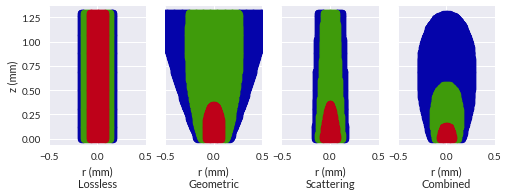

In [2]:
from matplotlib import colors
from brian2 import mm
import brian2.units.unitsafefunctions as usf

from clocsim.stimulators.opto import *

opto = OptogeneticIntervention(name='opto', opsin_model=four_state, 
        opsin_params=ChR2_four_state, light_model_params=default_blue)

x = np.linspace(-0.9, 0.9, 200)
y = np.linspace(-0.2, 1.3, 300)
x, y = np.meshgrid(x, y)
dir_uvec = np.array([[0], [1]])

coords = np.vstack([x.flatten(), y.flatten()]).T
coords = coords*mm
z = usf.dot(coords, dir_uvec)  # distance along cylinder axis
r = np.sqrt( np.sum( (coords-usf.dot(z, dir_uvec.T))**2, axis=1 ) )
r = r.reshape((-1, 1))

fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, sharey=True)
ax1.set_ylabel('z (mm)')

def plot_panel(ax, T, label):
    # filter out points with <0.001 transmittance to make plotting faster
    blue_T = 0.001
    idx_to_plot = T[:,0] >= blue_T
    x_plot = x.flatten()[idx_to_plot]; y_plot = y.flatten()[idx_to_plot]
    T = T[idx_to_plot, 0]
    def plot_interval(start, stop, color):
        idxs = (T >= start) & (T < stop)
        ax.scatter(x_plot[idxs], y_plot[idxs], c=color, marker='o')
    plot_interval(.001, .01, 'xkcd:royal blue')
    plot_interval(.01, .1, 'xkcd:grass green')
    plot_interval(.1, 1, 'xkcd:scarlet')
    ax.set_aspect('equal')
    ax.set_xlim((-.5, .5)); ax.set_xlabel(f'r (mm)\n{label}')

plot_panel(ax1, opto._Foutz12_transmittance(r, z, 
        spread=False, scatter=False), 'Lossless')
plot_panel(ax2, opto._Foutz12_transmittance(r, z, scatter=False), 'Geometric')
plot_panel(ax3, opto._Foutz12_transmittance(r, z, spread=False), 'Scattering')
plot_panel(ax4, opto._Foutz12_transmittance(r, z), 'Combined')

plt.show()

Qualitatively it looks pretty close. The scattering plot is the most off, but that could be a result of differences in how the plots are generated. They are using 3D shells which could be sliced at an angle and I'm using point samples.

### Transmission-distance plot
Next we'll try to replicate figure 2B from Foutz et al. 2012. The x-axis represents distance from light to the cell body, ranging from 0 to 2 mm. Each line is for optic fibers of different radii.

<img src="foutz12_2b.jpg" alt="Foutz et al. 2012 Figure 2B" width="500"/>

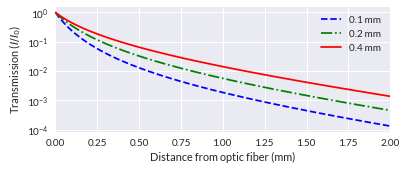

In [3]:
plt.figure(figsize=(6,2.3))
z = np.linspace(0, 2, 200)*mm
g = False
opto.light_model_params['R0'] = 0.05*mm
T1 = opto._Foutz12_transmittance(np.zeros_like(z), z, gaussian=g)
opto.light_model_params['R0'] = 0.2*mm
T4 = opto._Foutz12_transmittance(np.zeros_like(z), z, gaussian=g)
opto.light_model_params['R0'] = 0.1*mm
T2 = opto._Foutz12_transmittance(np.zeros_like(z), z, gaussian=g)
plt.plot(z/mm, T1, 'b--', label='0.1 mm')
plt.plot(z/mm, T2, 'g-.', label='0.2 mm')
plt.plot(z/mm, T4, 'r', label='0.4 mm')
plt.yscale('log')
plt.ylabel('Transmission ($I/I_0$)')
plt.xlabel('Distance from optic fiber (mm)')
plt.legend(); plt.grid(True); plt.tick_params(right=True, which='both')
plt.xlim(0, 2)
plt.show()

## Opsin model
Now let's see that the opsin model is working as expected. This chart is the result of the ramp protocol for ChR2 from PyRhO (Evans et al., 2016):

<img src="pyrho_ChR2_ramp.png" alt="PyRhO ChR2 ramp protocol" width="500"/>

WARNING    Cannot use Cython, a test compilation failed: command 'cl.exe' failed: No such file or directory (CompileError) [brian2.codegen.runtime.cython_rt.cython_rt.failed_compile_test]
INFO       Cannot use compiled code, falling back to the numpy code generation target. Note that this will likely be slower than using compiled code. Set the code generation to numpy manually to avoid this message:
prefs.codegen.target = "numpy" [brian2.devices.device.codegen_fallback]
INFO       No numerical integration method specified for group 'synapses', using method 'euler' (took 0.05s, trying other methods took 0.12s). [brian2.stateupdaters.base.method_choice]


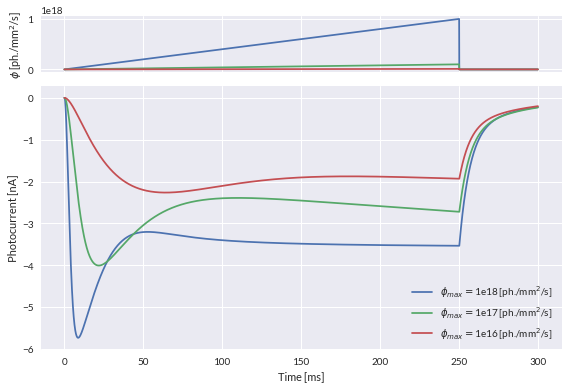

In [4]:
from brian2 import NeuronGroup, ms, StateMonitor, run, plot, Network, collect
from clocsim.coordinates import assign_coords_rect_prism

ng = NeuronGroup(3, '''
        v = -70*mV : volt
        Iopto : amp''',
)
assign_coords_rect_prism(ng, 'grid', (0,0), (0,0), (0,0), xyz_grid_shape=(3, 1, 1))
opto.connect_to_neurons(ng)

pulse_width = 250*ms

# converting from photon flux to irradiance at point (Irr) to fiber tip irradiance (Irr0)
# phi [1e18, 1e17, 1e16] * Ephoton / T
opto.opto_syn.run_regularly('''pulse = t < pulse_width
        Irr0_peak = 1e18/10**i /second/mm2 * Ephoton / T
        Irr0 = pulse * Irr0_peak * (t/pulse_width)
''', name='stim')

Omon = StateMonitor(opto.opto_syn, ['O1', 'C1', 'C2', 'O2', 'phi'], record=True)
Iopto_mon = StateMonitor(ng, ['Iopto'], record=True)

run(pulse_width + 50*ms)

### Plots
ax1 = plt.subplot2grid(shape=(5, 1), loc=(0,0))
ax1.plot(Omon.t/ms, Omon.phi.T*mm2)
ax1.set(ylabel='$\phi$ [ph./mm$^2$/s]', xticklabels=[])

ax2 = plt.subplot2grid(shape=(5, 1), loc=(1,0), rowspan=4)
ax2.plot(Iopto_mon.t/ms, Iopto_mon.Iopto_.T/namp)
ax2.set(ylabel='Photocurrent [nA]', xlabel='Time [ms]')
# ax2.legend([str(x) for x in [18, 17, 16]])
ax2.legend(['$\phi_{max}=$1e' + str(x) + ' [ph./mm$^2$/s]' for x in [18, 17, 16]])
plt.tight_layout()
plt.savefig('opto_ramp.png', transparent=True)

## Spatially dependent stimulation response

We will now check that neurons fire more in response to light when more propagated light reaches them. The firing rates should correlate to the light transmission profile we've already seen.

In [2]:
from brian2 import *
ng = NeuronGroup(150,
    '''dv/dt = (-v - 70*mV - Rm*Iopto) / tau : volt
    tau: second
    Rm: ohm
    Iopto: amp
    ''',
    threshold='v>-50*mV',
    reset='v=-70*mV'
)
ng.tau = 10*ms
ng.Rm = 100*Mohm
ng.v = -70*mV

pop_mon = SpikeMonitor(ng, record=True)

from clocsim.coordinates import assign_coords_rect_prism, plot_neuron_positions
assign_coords_rect_prism(ng, 'grid', xlim=(-.25, .25), ylim=(-.25, .25), 
    zlim=(0.2, 1.2), unit=mm, xyz_grid_shape=(5,5,6))

from clocsim.base import CLOCSimulator
net = Network(collect())
sim = CLOCSimulator(net)

from clocsim.stimulators.opto import *
opto = OptogeneticIntervention(name='opto', opsin_model=four_state, 
        opsin_params=ChR2_four_state, light_model_params=default_blue, location=(0,0,0)*mm)
sim.inject_stimulator(opto, ng)
opto.update(30)

sim.run(1000*ms)

WARNING    Cannot use Cython, a test compilation failed: command 'cl.exe' failed: No such file or directory (CompileError) [brian2.codegen.runtime.cython_rt.cython_rt.failed_compile_test]
INFO       Cannot use compiled code, falling back to the numpy code generation target. Note that this will likely be slower than using compiled code. Set the code generation to numpy manually to avoid this message:
prefs.codegen.target = "numpy" [brian2.devices.device.codegen_fallback]
INFO       No numerical integration method specified for group 'neurongroup', using method 'exact' (took 0.03s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synapses', using method 'euler' (took 0.05s, trying other methods took 0.13s). [brian2.stateupdaters.base.method_choice]


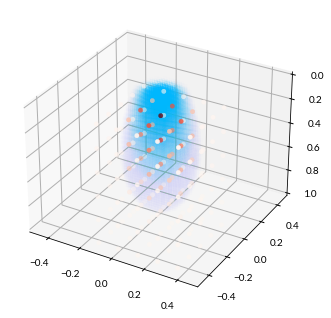

In [17]:
counts = np.bincount(pop_mon.i)
counts = np.hstack((counts, np.zeros(150 - len(counts))))

from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
c = counts/1000
# c[c==0] = 0
ax.scatter3D(ng.x/mm, ng.y/mm, ng.z/mm, c=c, cmap='Reds', depthshade=True);
ax.set_xlim(-.5, .5); ax.set_ylim(-.5, .5)
ax.set_zlim(1, 0)
opto.add_self_to_plot(ax, mm)
fig.savefig('opto_firing_rates.png', transparent=True)
with plt.style.context('dark_background'):
    fig.savefig('opto_firing_rates_dark.png', transparent=True)
# plt.plot(vmon.v.T / mvolt);